In [4]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASIM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Classification: Using Transformers Encoder Block
- A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data
- They hold the potential to understand the relationshipbetween sequential elements that are far from each other
- They are way more accurate 
- They pay equal attention to all the elements in the sequence

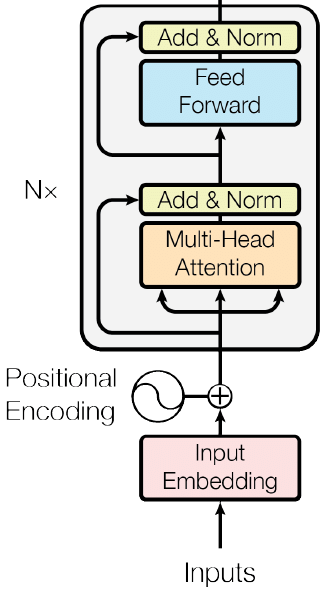

In [5]:
data1 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [6]:
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

In [7]:
data

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
55323,american politics in moral free-fall,0
55324,america's best 20 hikes,0
55325,reparations and obama,0
55326,israeli ban targeting boycott supporters raise...,0


# EDA and Text Preprocessing

## Checking for Missing Values

In [8]:
data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Finding the Classes Balance/Imbalance

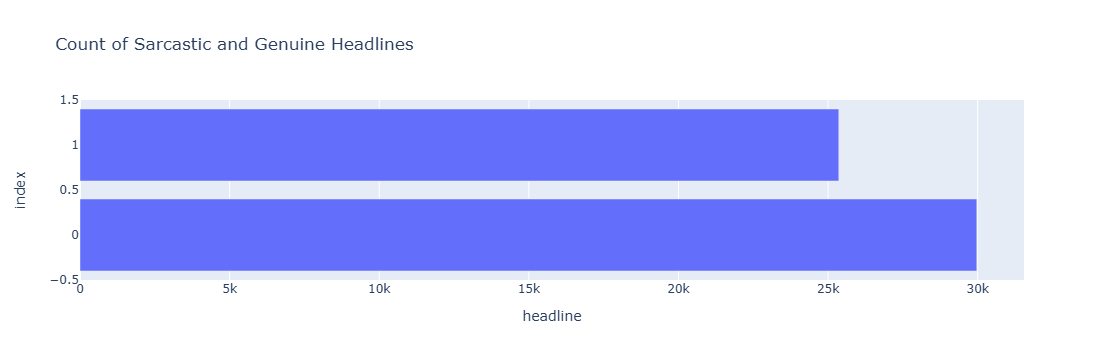

In [9]:
px.bar(data.groupby('is_sarcastic').count().reset_index(), x='headline',title='Count of Sarcastic and Genuine Headlines')

## Special Characters Removal
- We will not remove numbers from the text data right away, lets further analyse if they contain any relevant information
- We can find the entity type of the tokens in the sentences using Named Entity Recognition (NER), this will help us identify the type and relevance of numbers in our text data

In [10]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [12]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|████████████████████████████████████████████████████████████████████████████| 55328/55328 [16:48<00:00, 54.87it/s]


In [13]:
data['clean_headline'] = data['headline'].apply(text_cleaning)

In [14]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data

,headline,is_sarcastic,entity,clean_headline,sentence_length
0,thirtysomething scientists unveil doomsday clo...,1,CARDINAL,thirtysomething scientists unveil doomsday clo...,7
1,dem rep. totally nails why congress is falling...,0,"ORG,ORG",dem rep totally nail congress fall short gende...,10
2,eat your veggies: 9 deliciously different recipes,0,CARDINAL,eat veggies 9 deliciously different recipes,6
3,inclement weather prevents liar from getting t...,1,,inclement weather prevent liar get work,6
4,mother comes pretty close to using word 'strea...,1,,mother come pretty close use word stream corre...,8
...,...,...,...,...,...
55323,american politics in moral free-fall,0,NORP,american politics moral free fall,5
55324,america's best 20 hikes,0,"GPE,CARDINAL",america best 20 hike,4
55325,reparations and obama,0,,reparations obama,2
55326,israeli ban targeting boycott supporters raise...,0,NORP,israeli ban target boycott supporters raise al...,8


# Model Building


The following infographic provides an overview of the internal workings of the transformers.
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [30]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test Splitting (80:10:10)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenization
- Splitting sentences into words
- Finding the vocab size

In [32]:
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20880


## Encoding of Inputs
- Converting the sentences to token followed by padded sequences in encoded format
- These are numeric encodings assigned to each word

In [33]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Transformers: Attention is all you need
- For the purpose of classification problem we will only use the encoder block of the original transformers model (encoder-decoder) designed for sequence problems
- Image below is from Jay Alamar's Blog ( For detailed explanation: https://jalammar.github.io/illustrated-transformer/ )

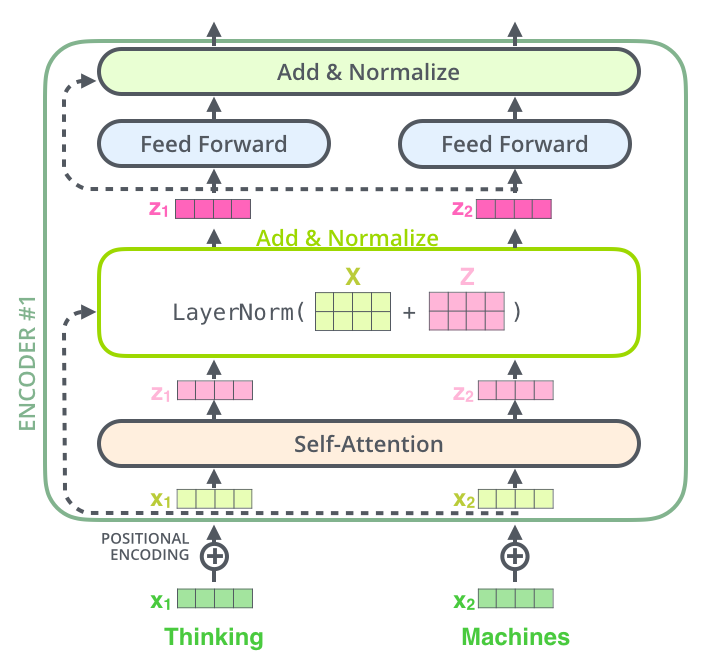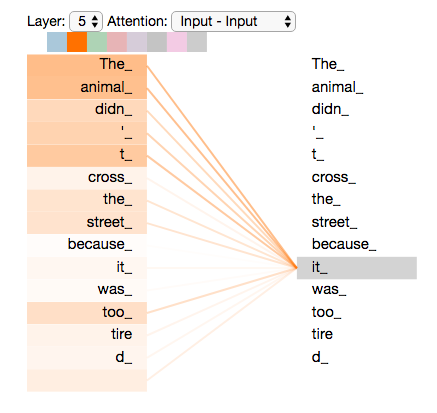

## Multi-Headed Attention
- Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. 
- The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention
- Multiple attention heads allows for attending to parts of the sequence differently
- During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel 

In [39]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## Model Definition

In [40]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_5       │ (None, 20, 50)              │       1,045,300 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_5                │ (None, 20, 50)              │          23,832 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 50)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,069,183 (4.08 MB)

 Trainable params: 1,069,183 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [43]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [44]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.6757 - loss: 0.5764 - val_accuracy: 0.8551 - val_loss: 0.3305
Epoch 2/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.9027 - loss: 0.2488 - val_accuracy: 0.8883 - val_loss: 0.2851
Epoch 3/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.9458 - loss: 0.1526 - val_accuracy: 0.9120 - val_loss: 0.2677
Epoch 4/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.9685 - loss: 0.0966 - val_accuracy: 0.9243 - val_loss: 0.2728
Epoch 4: early stopping


# Model Evaluation

## Learning Curves
- Loss Curve
- Accuracy Curve

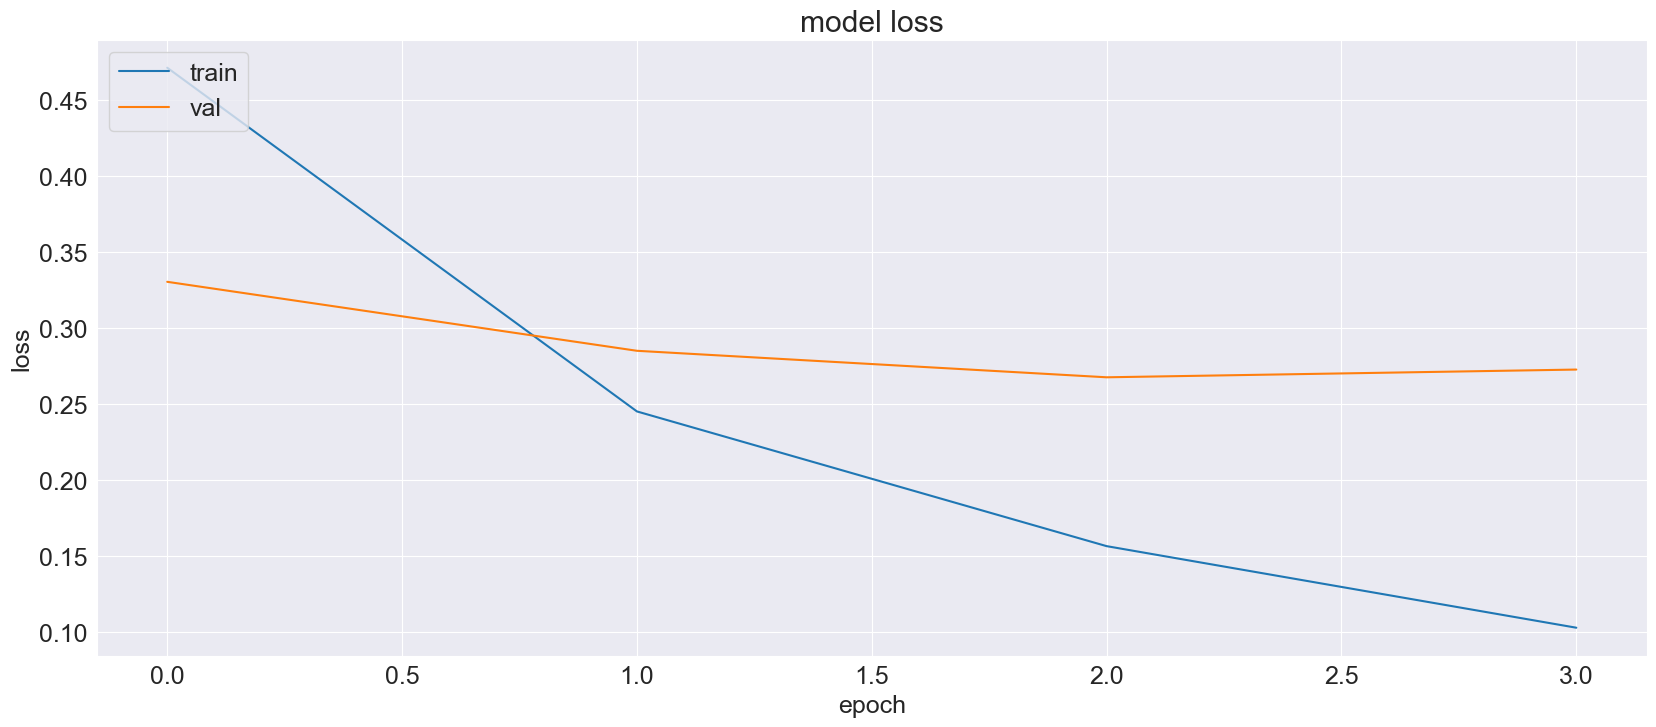

In [45]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

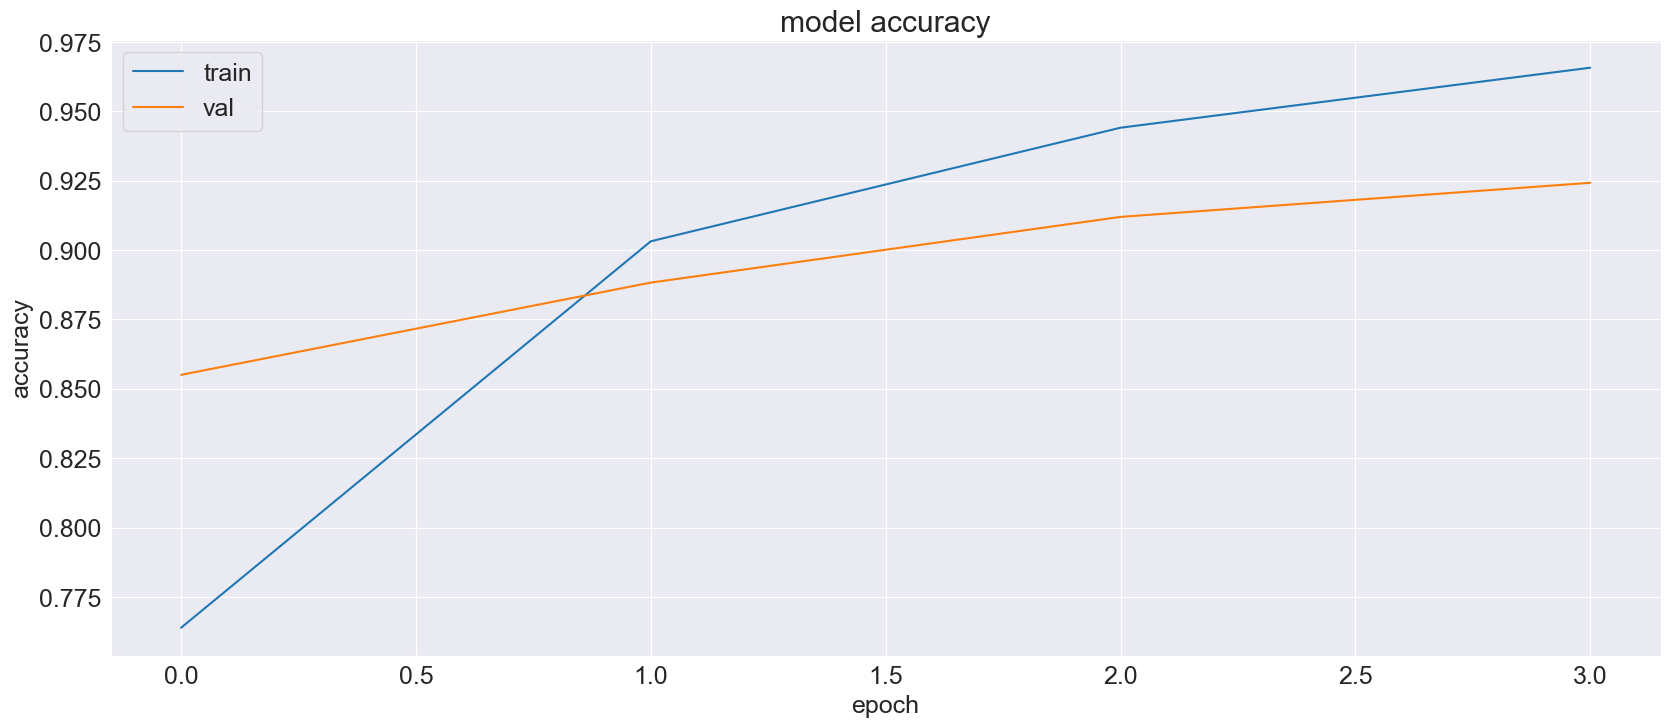

In [46]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Inference:** In case of overfitting use the traditional methods
- Low learning rate
- L1-L2 Regularization
- Dropout
- Lesser Neurons in MLP layers
- Early Stopping
- etc.

## Classification Metrics
- Since it is important to not misclassify the genuine headlines as sarcastic headlines we will also look at the roc auc score to avoid misclassification of genuine headlines as sarcastic headlines

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [52]:
y_pred = model.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [53]:
y_pred

array([[9.9957383e-01],
       [9.7280973e-01],
       [5.0709175e-04],
       ...,
       [1.3592131e-03],
       [9.9925804e-01],
       [5.4030628e-03]], dtype=float32)

### Scores: Test Set Result

In [58]:
#y_pred[y_pred>=0.85] = 1
#y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2997
           1       0.96      0.84      0.89      2536

    accuracy                           0.91      5533
   macro avg       0.92      0.90      0.91      5533
weighted avg       0.91      0.91      0.91      5533



### Confusion Matrix

<Axes: >

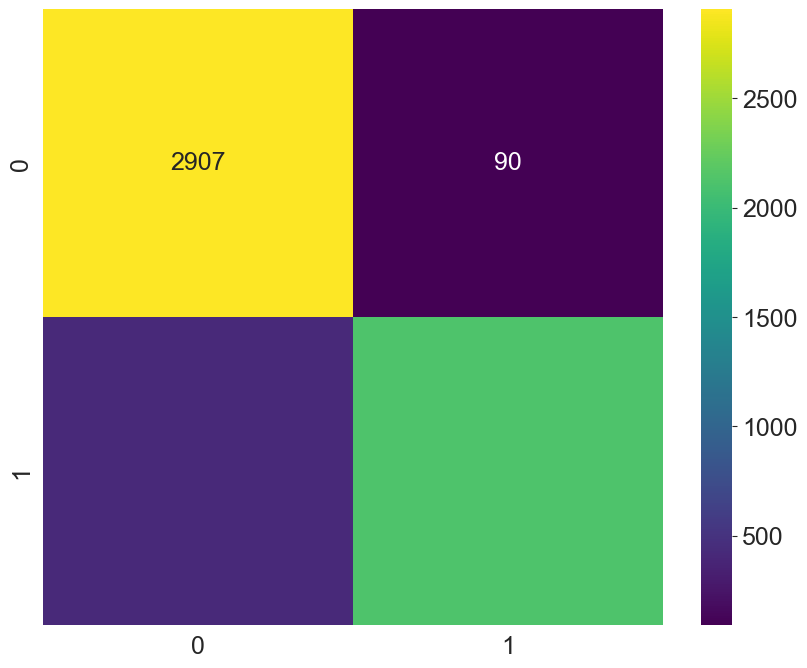

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')

In [63]:
 #Prediction Example
sample_text = ["inclement weather prevent liar get work"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_len)
prediction = model.predict(sample_padded)
print(f"\nPrediction: {'Sarcastic' if prediction[0] > 0.5 else 'Not Sarcastic'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Prediction: Not Sarcastic
